# Tutorial: MCMC Diagnostics

You should already have run one or two different MCMC algorithms to generate multiple chains from different strting points for the toy photometry problem. Here, we'll work through the process of diagnosing whether these Markov chains are usefully sampling the posterior distribution, in particular assessing:

* their convergence
* their autocorrelation
* the effective number of independent samples, and how this impacts the usual reported values and credible intervals

The diagnostics discussed below include both qualitative and quantitative checks. We don't particularly think it's all that instructive to write the code that does the quantitative calculations - though there is surely room for improvement or expansion if you're interested - so intead we will demonstrate how to use functions provided by the `incredible` and `pandas` packages.

Final note: if you have done both the [Gibbs Sampling](toy_photometry_gibbs.ipynb) and [Metropolis Sampling](toy_photometry_metro.ipynb) tutorials, then you can/should use your own chains below. If not, you can change the paths below to read in chains from the `solutions/` directory instead, for the case you haven't worked through.

In [1]:
TutorialName = 'mcmc_diag'
exec(open('tbc.py').read()) # define TBC and TBC_above
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from glob import glob
import incredible as cr

## Gibbs samples

It's nice to start with the Gibbs sampled chains, since (for this problem) they almost certainly look nicer. First, read them in. The way we did things in the previous tutorial, each entry in the `chains` list will be an $N_\mathrm{steps} \times N_\mathrm{parameters}$ array.

In [2]:
chains = [np.loadtxt(f) for f in glob('toy_gibbs_chain_*.txt.gz')] # change `saved` to `solutions` if need be

param_labels = [r'$x_0$', r'$y_0$', r'$\mu$', r'$\sigma$']

### Visual inspection

You've already used the most important method of vetting chains: visual inspection. The key questions are:
1. Do multiple, independent chains appear to be sampling the same distribution (have they _converged_ to the same distribution)?
2. Is there a clear "burn-in" period before convergence that should be eliminated?
3. Are the chains highly autocorrelated (taking small steps compared with the width of the posterior)? This is not an issue per se, if the chains are long enough, although it means the sampler is not moving as efficiently as one might hope.

Plot the parameter traces below, and answer these questions (qualitatively) for the conjugate Gibbs sampling chains.

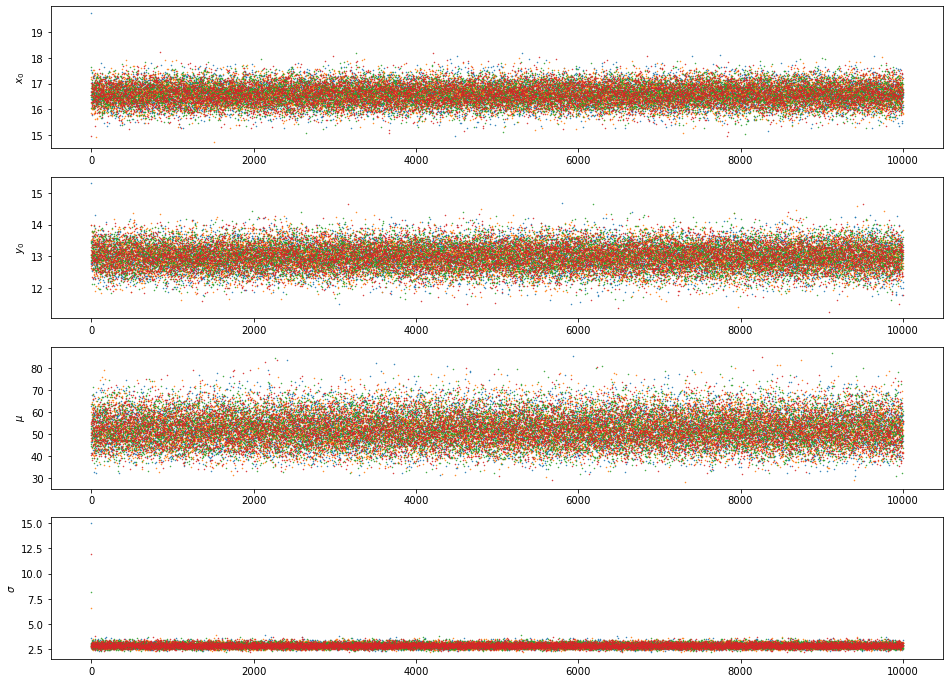

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(len(param_labels), 1);
cr.plot_traces(chains, ax, labels=param_labels, Line2D_kwargs={'markersize':1.0})

1. Do multiple, independent chains appear to be sampling the same distribution (have they _converged_ to the same distribution)? Yes
2. Is there a clear "burn-in" period before convergence that should be eliminated? In $x_0$ and $\sigma$, yes.
3. Are the chains highly autocorrelated (taking small steps compared with the width of the posterior)? no

Is there a burn-in that should clearly be removed? If so, do so here by setting the value of `burn` to a number of steps $>0$. (You shouldn't need to remove very much - if `burn=100`, for e.g., doesn't seem incredibly generous in this case, then something went wrong in the previous tutorial.)

In [4]:
burn = 100
for i in range(len(chains)):
    chains[i] = chains[i][burn:,:]

### Gelman-Rubin statistic

Recall from the [notes](../notes/mcmc_diagnostics.ipynb) that the Gelman-Rubin convergence statistic, $R$, quantitatively tests the similarlity of independent chains intended to sample the same PDF. To be meaningful, they should start from different locations and burn-in should be removed.

For a given parameter, $\theta$, the $R$ statistic compares the variance across chains with the variance within a chain. Intuitively, if the chains are random-walking in very different places, i.e. not sampling the same distribution, $R$ will be large.

We'd like to see $R\approx 1$; for example, $R<1.1$ is often used.

In [5]:
cr.GelmanRubinR(chains)

array([0.99996023, 1.00008215, 0.99998993, 0.99996601])

**Checkpoint:** If your Gibbs sampler works properly, $R$ for the chains we ran should be _very_ close to 1 (we have differences of order 0.0001).

### Autocorrelation

Similarly, the autocorrelation of a sequence, as a function of lag, $k$, can be quantified:

$\rho_k = \frac{\mathrm{Cov}_i\left(\theta_i,\theta_{i+k}\right)}{\mathrm{Var}(\theta)}$

The larger lag one needs to get a small autocorrelation, the less informative individual samples are.

The `pandas` function `plotting.autocorrelation_plot()` is useful for this. Note that seemingly random oscillations basically tell us the level of noise due to the fininte chain length. A coherent drop as a function of lag indicates a genuine autocorrelation, and the lag at which it drops to within the noise is an approximate autocorrelation length. If we needed to thin the chains to conserve disk space, this would be a reasonable factor to thin by.

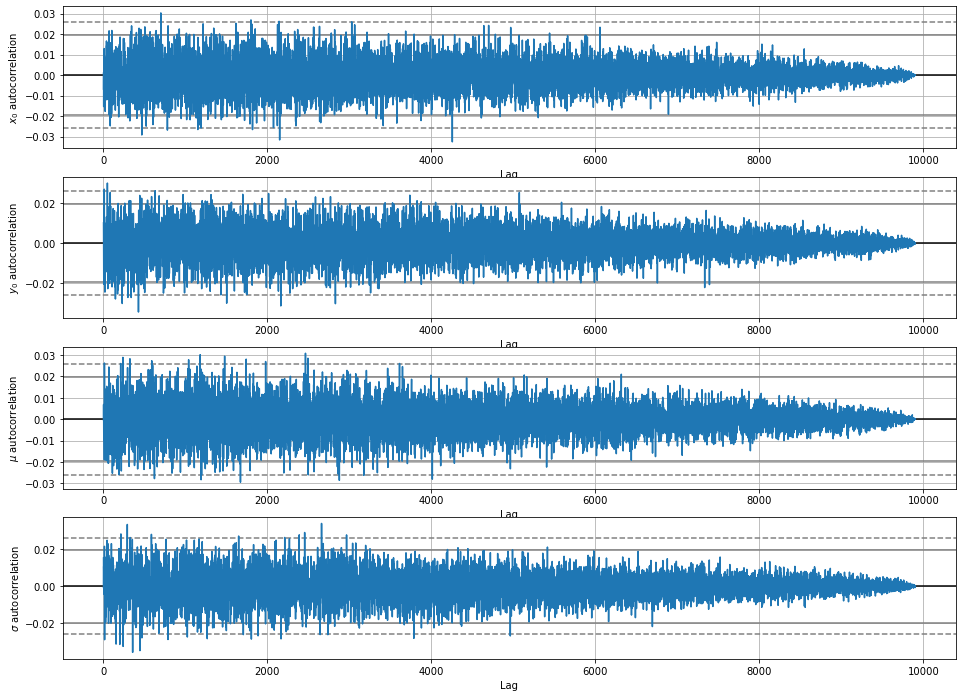

In [6]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(len(param_labels), 1);
for j,lab in enumerate(param_labels):
    pd.plotting.autocorrelation_plot(chains[0][:,j], ax=ax[j]);
    ax[j].set_ylabel(lab+' autocorrelation')

**Checkpoint:** Again, for this problem, the Gibbs chains should be very well behaved. Our autocorrelation plots basically look like noise (almost all points within the horizontal, dashed lines that `pandas` provides as an estimate of the noise).

### Effective number of independent samples

From $m$ chains of length $n$, we can also estimate the "effective number of independent samples" as

$n_\mathrm{eff} = \frac{mn}{1+2\sum_{t=1}^\infty \hat{\rho}_t}$, with

$\hat{\rho}_t = 1 - \frac{V_t}{2V}$ ($V$ as in the Gelman-Rubin calculation), and

$V_t = \frac{1}{m(n-t)} \sum_{j=0}^m \sum_{i=t+1}^n (\theta_{i,j} - \theta_{i-t,j})^2$.

In practice, the sum in $n_\mathrm{eff}$ is cut off when the estimates $\hat{\rho}_t$ become "too noisy", e.g. when the sum of two successive values $\hat{\rho}_t$ and $\hat{\rho}_{t+1}$ is negative. Roughly speaking, this should occur when the lag is of the order of the autocorrelation length.

The `effective_samples` below function allows you to pass a guess at this maximum lag, since doing the calculation to arbitrarily long lags becomes very expensive. It will issue a warning if it thinks this maximum lag is too small, according to the criterion above.

In [7]:
cr.effective_samples(chains, maxlag=500) # `maxlag' might be something you need to play with, in practice

array([38231.92559463, 39600.        , 39600.        , 38747.77738701])

Since we started with 4 chains of length 10,000 (possibly minus a little burn-in), $n_\mathrm{eff}$ values close to 40,000 are telling us that the autocorrelation is indeed quite small, in agreement with the plots above. Let's remember that this need not be true for every problem; Gibbs sampling is not independence sampling and produces a Markov chain that in principle could be highly correlated, depending on the model and data involved.

Note that, as with the Gelman-Rubin statistic, this is a case where one might be interested in seeing the effective number of samples for the most degenerate linear combinations of parameters, rather than the parameters themselves.

### Something to do

By now you are probably bored. Don't worry. Here is some work for you to do.

Let's get a sense of how many samples are _really_ needed to, e.g., determine 1D credible intervals (as opposed to making the whole posterior look nice). Remember that the effective number of samples is less than the total.

At this point, we're done comparing the individual chains, so we can lump them all together into one massive list of MCMC samples.

In [8]:
chain = np.concatenate(chains, axis=0)

For reference the total number of samples is:

In [9]:
chain.shape[0]

39600

We'll name the results using this full chain `40k` in the expectation that the length is still close to 40,000 steps, even after removing burn-in.

Let's have a look at the credible interval calculation for $\mu_0$.

39600 samples


{'mode': 51.28701461963772,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68610186, 0.95472501]),
 'density': array([0.03257001, 0.00755798]),
 'min': array([44.54580613, 38.37588649]),
 'max': array([59.17080082, 67.39736034]),
 'low': array([ -6.74120849, -12.91112813]),
 'high': array([ 7.8837862 , 16.11034572]),
 'center': array([51.85830347, 52.88662341]),
 'width': array([ 7.31249735, 14.51073692])}

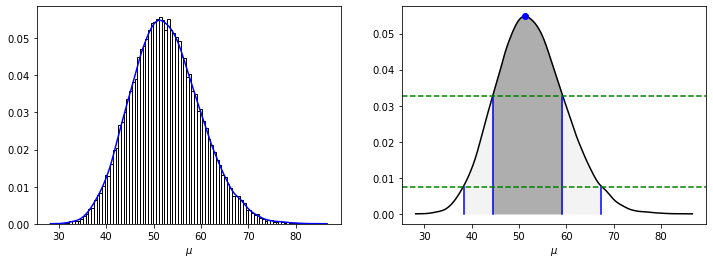

In [10]:
print(chain.shape[0], 'samples')
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1, 2);
h40k = cr.whist(chain[:,2], plot=ax[0])
ci40k = cr.whist_ci(h40k, plot=ax[1]);
ax[0].set_xlabel(r'$\mu$');
ax[1].set_xlabel(r'$\mu$');
ci40k

The PDF estimate should look pretty reliable with so many samples. The question is, if we're going to reduce this to a statement like $\mu=X^{+Y}_{-Z}$, keeping only up to the leading significant figure of $Y$ and $Z$, how many did we actually need to keep?

Thin the chain by factors of 4, 40, and 400 (to produce chains of length about 10000, 1000 and 100), and see how the _endpoints_ of the 68.3% credible intervals compare. We're looking at the endpoints rather than the values of $Y$ and $Z$ above because the latter are more volatile (depending also on the estimate of $X$).

Remember that thinning by a factor of 4 means that we keep only every 4th entry in the chain, not that we simply select the first 25% of samples. So we're not answering how long we needed to bother _running_ the chain to begin with - that's a slightly different question. We're finding out how redundant our samples are, not just in the "effective independence" sense, but for the specific purpose of quantifying this credible interval.

In [14]:
chain.shape

(39600, 4)

39600 samples


{'mode': 52.52920774782771,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68388679, 0.95461996]),
 'density': array([0.03207064, 0.00655489]),
 'min': array([44.50136859, 36.98055085]),
 'max': array([59.03598265, 66.8103111 ]),
 'low': array([ -8.02783916, -15.5486569 ]),
 'high': array([ 6.5067749 , 14.28110335]),
 'center': array([51.76867562, 51.89543097]),
 'width': array([ 7.26730703, 14.91488013])}

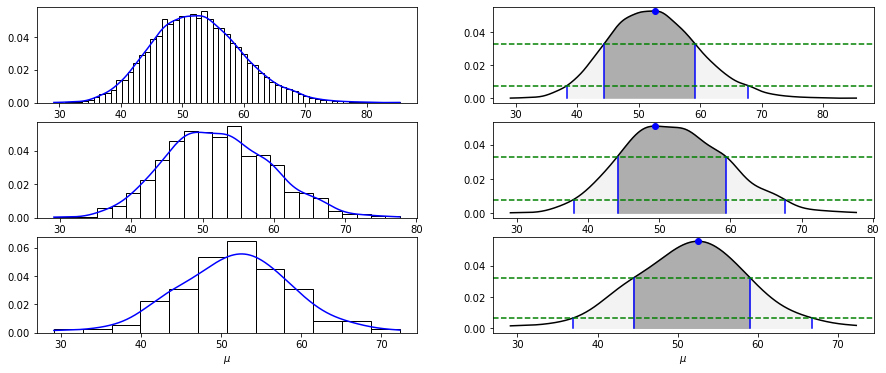

In [18]:
print(chain.shape[0], 'samples')
plt.rcParams['figure.figsize'] = (15.0, 6.0)
fig, ax = plt.subplots(3, 2);
h10k = cr.whist(chain[::4,2], plot=ax[0][0])
h1k = cr.whist(chain[::40,2], plot=ax[1][0])
h100 = cr.whist(chain[::400,2], plot=ax[2][0])
ci10k = cr.whist_ci(h10k, plot=ax[0][1]);
ci1k = cr.whist_ci(h1k, plot=ax[1][1]);
ci100 = cr.whist_ci(h100, plot=ax[2][1]);
ax[2][0].set_xlabel(r'$\mu$');
ax[2][1].set_xlabel(r'$\mu$');
ci10k
ci1k
ci100
# Analogous to the cell above, save the output of `whist` in h10k, h1k, h100, and the output of
# whist_ci in ci10k, ci1k and ci100. This is so we can plot them all togther later.

**Checkpoint:** Your mileage may vary slightly, of course. But we got a difference of unity at most, for a CI that was nominally $\pm7$ or so.

... which is a little surprising, honestly, even though we knew the autocorrelation was quite low in this case. But here's a slightly different question: which of the possible results would you be confident enough to put in a paper, having looked at the marginalized PDFs above? (The cell below compares them on the same plot, along with the 1 and 2$\sigma$ CIs.) And, relatedly, which one would you actually want to show in a figure?

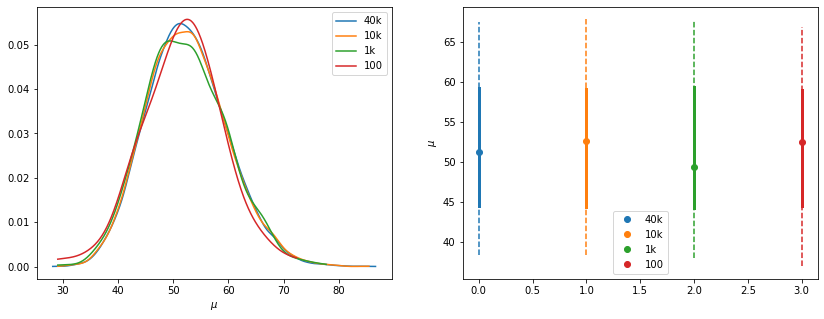

In [19]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1, 2);
ax[0].plot(h40k['x'], h40k['density'], '-', label='40k');
ax[0].plot(h10k['x'], h10k['density'], '-', label='10k');
ax[0].plot(h1k['x'], h1k['density'], '-', label='1k');
ax[0].plot(h100['x'], h100['density'], '-', label='100');
ax[0].legend();
ax[0].set_xlabel(r'$\mu$');
ax[1].plot(0.0, ci40k['mode'], 'o', color='C0', label='40k');
ax[1].plot([0.0]*2, [ci40k['min'][0],ci40k['max'][0]], '-', color='C0', linewidth=3);
ax[1].plot([0.0]*2, [ci40k['min'][1],ci40k['max'][1]], '--', color='C0');
ax[1].plot(1.0, ci10k['mode'], 'o', color='C1', label='10k');
ax[1].plot([1.0]*2, [ci10k['min'][0],ci10k['max'][0]], '-', color='C1', linewidth=3);
ax[1].plot([1.0]*2, [ci10k['min'][1],ci10k['max'][1]], '--', color='C1');
ax[1].plot(2.0, ci1k['mode'], 'o', color='C2', label='1k');
ax[1].plot([2.0]*2, [ci1k['min'][0],ci1k['max'][0]], '-', color='C2', linewidth=3);
ax[1].plot([2.0]*2, [ci1k['min'][1],ci1k['max'][1]], '--', color='C2');
ax[1].plot(3.0, ci100['mode'], 'o', color='C3', label='100');
ax[1].plot([3.0]*2, [ci100['min'][0],ci100['max'][0]], '-', color='C3', linewidth=3);
ax[1].plot([3.0]*2, [ci100['min'][1],ci100['max'][1]], '--', color='C3');
ax[1].legend();
ax[1].set_ylabel(r'$\mu$');

Just to belabor the point, here are the `mode` and `-low +high` CIs for the 4 cases, at the precision we would actually report. With the chains in `solutions/`, the only non-trivial difference is in the 100-sample case. (And this is with the default histogram smoothing, which we would possibly tweak in that case.)

In [20]:
print('~40k samples:', int(np.round(ci40k['mode'])), int(np.round(ci40k['low'][0])), '+'+str(int(np.round(ci40k['high'][0]))))
print('~10k samples:', int(np.round(ci10k['mode'])), int(np.round(ci10k['low'][0])), '+'+str(int(np.round(ci10k['high'][0]))))
print(' ~1k samples:', int(np.round(ci1k['mode'])), int(np.round(ci1k['low'][0])), '+'+str(int(np.round(ci1k['high'][0]))))
print('~100 samples:', int(np.round(ci100['mode'])), int(np.round(ci100['low'][0])), '+'+str(int(np.round(ci100['high'][0]))))

~40k samples: 51 -7 +8
~10k samples: 53 -8 +6
 ~1k samples: 49 -5 +10
~100 samples: 53 -8 +7


To belabor it even more, if we looked at the $\geq 1000$ sample PDFs and reasonably decided that they warranted symmetric CIs, these are the `center +- width` CIs we would report:

In [21]:
print('~40k samples:', int(np.round(ci40k['center'][0])), '+/-', int(np.round(ci40k['width'][0])))
print('~10k samples:', int(np.round(ci10k['center'][0])), '+/-', int(np.round(ci10k['width'][0])))
print(' ~1k samples:', int(np.round(ci1k['center'][0])), '+/-', int(np.round(ci1k['width'][0])))
print('~100 samples:', int(np.round(ci100['center'][0])), '+/-', int(np.round(ci100['width'][0])))

~40k samples: 52 +/- 7
~10k samples: 52 +/- 7
 ~1k samples: 52 +/- 8
~100 samples: 52 +/- 7


The bottom line is that summarizing a posterior with 1D best values and CIs is not, in fact, all that demanding in terms of the number of samples... provided that those samples are close to independent. Making a visual of the PDF in 1D or 2D that looks like it isn't noise dominated is often significantly more demanding. The upshot is that, if we have enough samples for the posterior plots to look not-noise-dominated, we can usually be pretty confident about numbers we report from them.

## Metropolis samples

Now, read in the Metropolis chains and perform the same checks. Again, use the chains in `solutions/` if you didn't work the Metropolis notebook yourself.

In [24]:
chains = [np.loadtxt(f) for f in glob('toy_metro_chain_*.txt.gz')]

Below we plot the traces. Address the same 3 questions posed for the Gibbs samples.

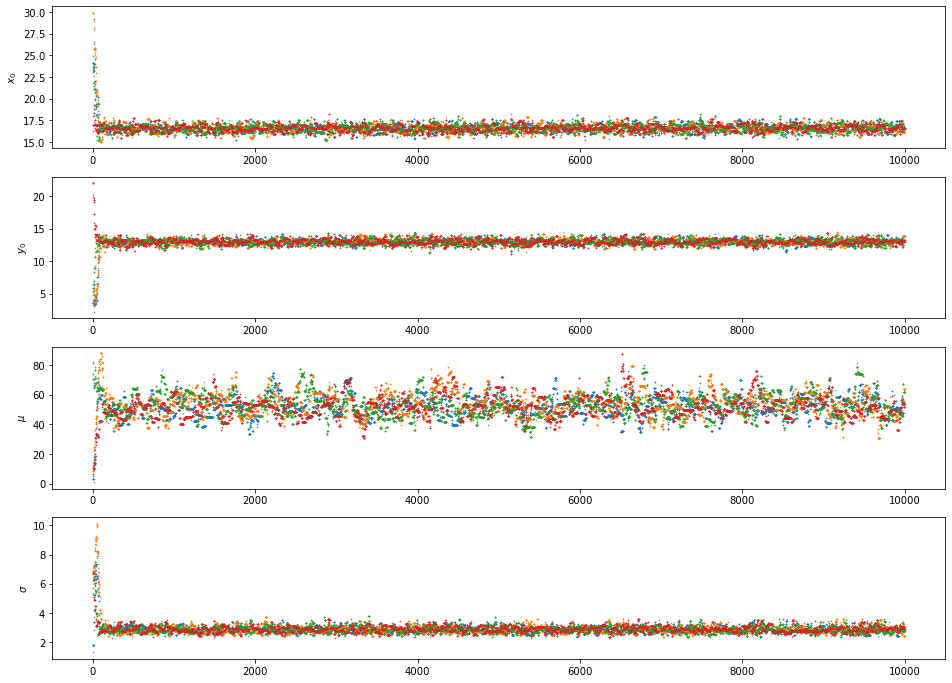

In [25]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(len(param_labels), 1);
cr.plot_traces(chains, ax, labels=param_labels, Line2D_kwargs={'markersize':1.0})

On the basis of the traces above, choose a burn-in length to remove from the beginning of each chain.

In [26]:
burn = 300
for i in range(len(chains)):
    chains[i] = chains[i][burn:,:]

Here we compute the G-R criterion:

In [27]:
cr.GelmanRubinR(chains)

array([1.00015371, 1.00006927, 1.00598509, 1.00112028])

**Checkpoint:** Your results will depend on the proposal distribution you used, but in this problem it's possible to get $R$ values very close to 1 again, though a bit larger than in the Gibbs case.

Next, we'll look at the autocorrelation plot:

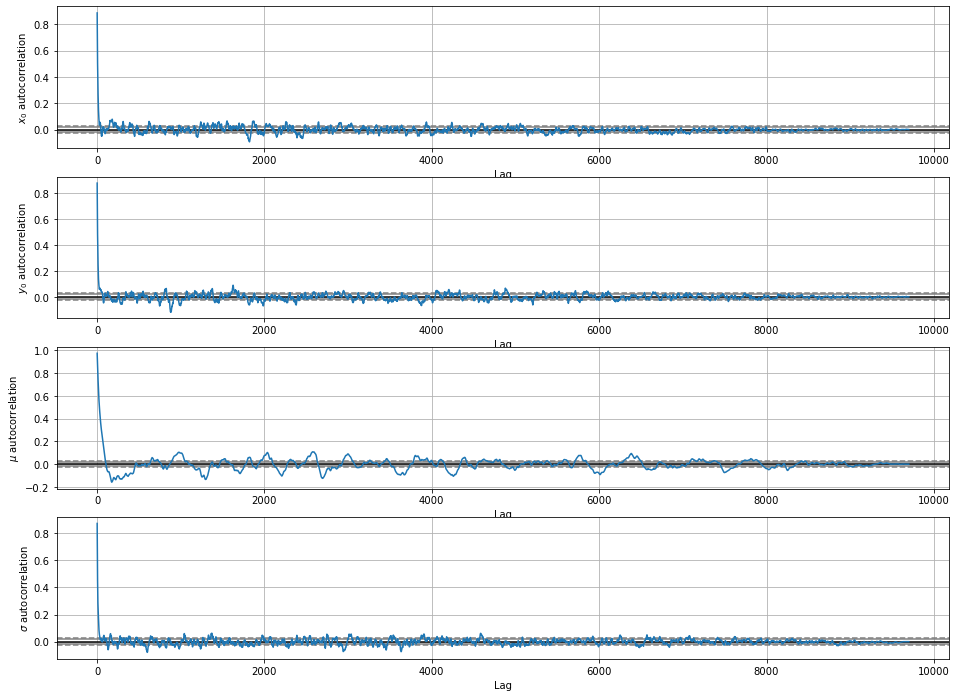

In [28]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(len(param_labels), 1);
for j,lab in enumerate(param_labels):
    pd.plotting.autocorrelation_plot(chains[0][:,j], ax=ax[j]);
    ax[j].set_ylabel(lab+' autocorrelation')

This should look qualitatively different from the Gibbs case, in that there is a clear sign of correlation at small lags.

Next, the effective number of samples.

In [29]:
cr.effective_samples(chains, maxlag=1000)

array([2270.08362157, 1906.30692741,  468.40783409, 1890.46025065])

**Checkpoint:** This will likely be **much** smaller than it was for the Gibbs chains.

That being the case, we won't bother repeating the thinning exercise above. However, it's worth looking at the _unthinned_ posterior for $\mu_0$ from Metropolis, with only $\sim400$ effectively independent samples (in the `solutions` chains), in the context of that exercise as it was done for Gibbs.

Total samples: 38800


{'mode': 52.56875629097841,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68503508, 0.95485244]),
 'density': array([0.03563578, 0.00580984]),
 'min': array([44.37251442, 37.94843295]),
 'max': array([58.54979766, 67.41059968]),
 'low': array([ -8.19624187, -14.62032334]),
 'high': array([ 5.98104137, 14.84184339]),
 'center': array([51.46115604, 52.67951632]),
 'width': array([ 7.08864162, 14.73108337])}

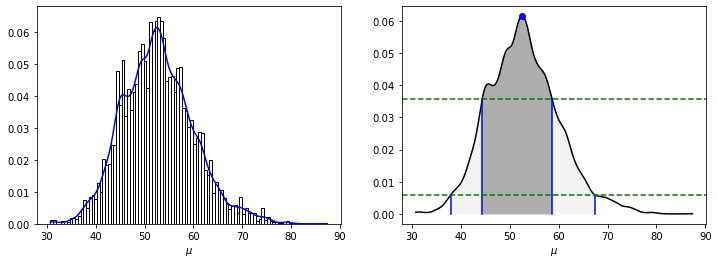

In [30]:
chain = np.concatenate(chains, axis=0)
print('Total samples:', chain.shape[0])
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1, 2);
hmetro = cr.whist(chain[:,2], plot=ax[0])
cimetro = cr.whist_ci(hmetro, plot=ax[1]);
ax[0].set_xlabel(r'$\mu$');
ax[1].set_xlabel(r'$\mu$');
cimetro

Very likely, you can see this posterior histogram retains significant noise due to the correlation of the chains, comparable to a much shorter chain of independent samples. The good news is that, as ugly as it looks, our summary of the best value and CI is still essentially what it should be, comparing with the results above.

## Parting thoughts

Hopefully this notebook has given you some practice with evaluating MCMC results and deciding how trustworthy they are. We do want to emphasize again that any conclusions about the relative performance of the two samplers involved are not generalizable. Conjugate Gibbs is often, but not always, a very nice option when the model permits it. On the other hand, we're not seeing Metropolis at its best; it can be enhanced in ways that improve its performance beyond what we've seen here (we'll cover some in [later notes](../notes/more_samplers.ipynb)). Combined with the fact that it can be used with any likelihood and prior, Metropolis sampling is an essential tool.